In [ ]:
!nvidia-smi

Mon Sep 13 01:49:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import pickle

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

In [ ]:
# Install torch-geometric
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

     |████████████████████████████████| 8.0 MB 8.9 MB/s 
     |████████████████████████████████| 2.9 MB 7.6 MB/s 
     |████████████████████████████████| 376 kB 9.4 MB/s 
     |████████████████████████████████| 45 kB 4.2 MB/s 


In [ ]:
import torch_geometric
import torch_geometric.nn as geom_nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/MSc_Project_Ellen/

/content/drive/MyDrive/MSc_Project_Ellen


In [ ]:
ls

 Behler_Parrinello_NN_final.ipynb            Models_GNN/
 Behler_Parrinello_NN_padding_10_4_2.ipynb   neural_xc_playground/
 BP_CV_log.txt                               old_notebooks/
'Copy of Behler_Parrinello_NN_final.ipynb'   openff_openmm.ipynb
'Copy of GNN_final.ipynb'                    Plots/
 Dataset/                                    pyscf.ipynb
 dataset_BP_clean/                           test_padding_14_6_2.ipynb
 dataset_GNN_clean/                          test_padding_20_20_5.ipynb
 GNN_CV_log.txt                              test.pdb
 GNN_final.ipynb                             test.pickle
 GNN.ipynb                                   test.xyz
 Models_BP/                                  tmp.txt


## "globals"

In [ ]:
# order of atoms in a molecule
_ORDER_ = {"methane":["C","H","H","H","H"], 
         "ethane":["C","C","H","H","H","H","H","H"], 
         "propane":["C","C","H","H","H","H","H","C","H","H","H"], 
         "butane":["C","C","H","H","H","H","H","C","H","C","H","H","H","H"], 
         "isobutane":["C","C","C","H","C","H","H","H","H","H","H","H","H","H"],
         "water":["O","H","H"],
         "benzene":["C","C","C","C","C","C","H","H","H","H","H","H"],
         "toluene":["C","C","C","C","C","C","C","H","H","H","H","H","H","H","H"],
         "malonaldehyde":["C","C","C","O","O","H","H","H","H"],
         "ethanol":["C","C","O","H","H","H","H","H","H"],
         "ethylene":["C","C","H","H","H","H"],
         "acetylene":["C","C","H","H"],
         "propene":["C","C","C","H","H","H","H","H","H"],
         "methanol":["C","O","H","H","H","H"],
         "ethanal":["C","C","O","H","H","H","H"],
         "dimethylether":["C","O","C","H","H","H","H","H","H"]
         }

In [ ]:
# n and l for each element of a particular basis
_BASIS_ = {"ccpvtz":{"H":{"n":3, "l":3},
                     "C":{"n":4, "l":4},
                     "O":{"n":4, "l":4}}}

In [ ]:
# connectivity between atoms in a molecule 
_EDGES_ = {"methane":[[0,1,0,2,0,3,0,4],
                      [1,0,2,0,3,0,4,0]], 
         "ethane":[[0,1,0,2,0,3,0,4,1,5,1,6,1,7],
                   [1,0,2,0,3,0,4,0,5,1,6,1,7,1]], 
         "propane":[[0,1,0,2,0,3,0,4,1,5,1,6,1,7,7,8,7,9,7,10],
                    [1,0,2,0,3,0,4,0,5,1,6,1,7,1,8,7,9,7,10,7]], 
         "butane":[[0,1,0,2,0,3,0,4,1,5,1,6,1,7,7,8,7,9,7,10,9,11,9,12,9,13],
                   [1,0,2,0,3,0,4,0,5,1,6,1,7,1,8,7,9,7,10,7,11,9,12,9,13,9]], 
         "isobutane":[[0,1,0,2,0,3,0,4,1,5,1,6,1,7,2,8,2,9,2,10,4,11,4,12,4,13],
                      [1,0,2,0,3,0,4,0,5,1,6,1,7,1,8,2,9,2,10,2,11,4,12,4,13,4]],
         "water":[[0,1,0,2],
                  [1,0,2,0]],
         "benzene":[[0,6,1,7,2,8,3,9,4,10,5,11,0,1,1,2,2,3,3,4,4,5,5,0],
                    [6,0,7,1,8,2,9,3,10,4,11,5,1,0,2,1,3,2,4,3,5,4,0,5]],
         "toluene":[[0,1,0,7,0,8,0,9,2,10,3,11,4,12,5,13,6,14,1,2,2,3,3,4,4,5,5,6,6,1],
                    [1,0,7,0,8,0,9,0,10,2,11,3,12,4,13,5,14,6,2,1,3,2,4,3,5,4,6,5,1,6]],
         "malonaldehyde":[[0,1,0,4,0,5,1,6,1,7,1,2,2,3,2,8],
                          [1,0,4,0,5,0,6,1,7,1,2,1,3,2,8,2]],
         "ethanol":[[0,1,0,2,0,3,0,4,1,5,1,6,1,7,2,8,],
                    [1,0,2,0,3,0,4,0,5,1,6,1,7,1,8,2]],
         "ethylene":[[0,1,0,2,0,3,1,4,1,5],
                     [1,0,2,0,3,0,4,1,5,1]],
         "acetylene":[[0,1,0,2,1,3],
                      [1,0,2,0,3,1]],
         "propene":[[0,1,0,6,0,7,0,8,1,5,1,2,2,3,2,4],
                    [1,0,6,0,7,0,8,0,5,1,2,1,3,2,4,2]],
         "methanol":[[0,1,0,2,0,3,0,4,1,5],
                     [1,0,2,0,3,0,4,0,5,1]],
         "ethanal":[[0,1,0,3,0,4,0,5,1,2,1,6],
                    [1,0,3,0,4,0,5,0,2,1,6,1]],
         "dimethylether":[[0,1,0,3,0,4,0,5,1,2,2,6,2,7,2,8],
                          [1,0,3,0,4,0,5,0,2,1,6,2,7,2,8,2]]
         }

## utiliy

In [ ]:
def trace_sym(c:np.ndarray, m:str, basis:str="ccpvtz"):
    """
    trace symmetriser d_{nl} = \sum_m c_{nlm}^2
    Input:
    c     - flattened unsymmetrised projectors
    m     - molecule name
    basis - the basis of which the density is projected onto
    Output:
    d     - symmetrised and padded descriptors (H, C and O padded to 10, 4 and 2, respectively)
    """
    max_atom_d_length = 0
    for atom  in _BASIS_[basis]:
        atom_d_length = _BASIS_[basis][atom]['n']*_BASIS_[basis][atom]['l']
        if atom_d_length > max_atom_d_length:
            max_atom_d_length = atom_d_length

    d_out = []
    idx = 0
    #symmetrize
    for atom in _ORDER_[m]:
        n_max = _BASIS_[basis][atom]["n"]
        l_max = _BASIS_[basis][atom]["l"]
        for n in range(n_max):
            for l in range(l_max):
                d_out += [np.linalg.norm(c[idx:idx+(2*l+1)])**2]
                idx += 2*l+1
        d_out += [0] * (max_atom_d_length - n_max * l_max) #padding
    d_out = np.array(d_out)
    return d_out

In [ ]:
def combine_xy(ms:list):
    """[0:-1] columns are the descriptors and the -1 column will be the target correction energy in eV"""
    output_list = []
    for name in ms:
        stacked_descirptors = []
        cs = np.load(f"neural_xc_playground/tmp_{name}/ccpvdz2ccpvtz_p/p.npy")
        for i in range(len(cs)):
            stacked_descirptors.append(trace_sym(cs[i], name.split('_')[0], "ccpvtz"))
        stacked_ds = np.array(stacked_descirptors)
        pbe_energy = np.loadtxt(f"Dataset/energy/{name}_pbe.txt")
        cc_energy = np.loadtxt(f"Dataset/energy/{name}_cc.txt")
        delta_e = (cc_energy - pbe_energy) *27.2114
        output_list.append(np.hstack((stacked_ds, delta_e.reshape(-1,1))))
    output = output_list[0]
    if len(output_list) > 1:
        for tmp in output_list[1:]:
            output = np.vstack((output, tmp))
    f_n = ms[0].split('_')[0]
    np.save(f"dataset_GNN_clean/{f_n}_labelled_ds.npy", output)
    return 

In [ ]:
def split_data(ms:list, ratio=0.8):
    "slpit data randomly into training and testing set, ratio is the % of training data"
    np.random.seed(0)
    train = []
    test = []
    for name in ms:
        data = np.load(f"dataset_GNN_clean/{name}_labelled_ds.npy")
        np.random.shuffle(data)
        train.append((data[:int(ratio*data.shape[0])], name)) #tuple (data, molecule name)
        test.append((data[int(ratio*data.shape[0]):], name))
    return train, test

In [ ]:
def split_equally(data_in:list, k:int=2):
    "split into k parts"
    output = []
    for i in range(k):
        output_i = []
        for (data, name) in data_in:
            length = len(data)
            batch = int(length/k)
            start = i*batch
            end = (i+1)*batch if (i+1)*batch <= length else -1
            output_i.append((data[start:end], name))
        output.append(output_i)
    return output

In [ ]:
def select_k(data_in:list, k:int=10):
    "select first k samples"
    output = []
    for (data, name) in data_in:
        output.append((data[:k], name))
    return output

In [ ]:
# def combine_split(data_in:list):
#     output = data_in[0]
#     n_molecules = len(data_in[0])
#     for data in data_in[1:]:
#         for m in range(n_molecules)



## a GCN model

based on https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing

In [ ]:
# class GCN(nn.Module):
#     def __init__(self, hidden_channels, basis:str="ccpvtz"):
#         super(GCN, self).__init__()
#         torch.manual_seed(12345)
#         self.conv1 = geom_nn.GCNConv(16, hidden_channels)
#         self.conv2 = geom_nn.GCNConv(hidden_channels, hidden_channels)
#         self.conv3 = geom_nn.GCNConv(hidden_channels, hidden_channels)
#         self.lin = nn.Sequential(nn.Linear(hidden_channels, 64), nn.GELU(), nn.Linear(64,1))

#     def forward(self, x, edge_index):
#         # 1. Obtain node embeddings 
#         x = self.conv1(x, edge_index)
#         x = nn.GELU()(x)
#         x = self.conv2(x, edge_index)
#         x = nn.GELU()(x)
#         x = self.conv3(x, edge_index)

#         # 2. Readout layer, taking the mean
#         x = torch.sum(x, dim=1)  

#         # 3. Apply the final linear classifier
#         x = self.lin(x)
        
#         return torch.squeeze(x)

In [ ]:
class GCN(nn.Module):
    def __init__(self, hidden_channels:list=[16,16,16,16,1], acti=nn.Tanh(), basis:str="ccpvtz"):
        super(GCN, self).__init__()

        max_d_length = 0
        for atom  in _BASIS_[basis]:
            d_length = _BASIS_[basis][atom]['n']*_BASIS_[basis][atom]['l']
            if d_length > max_d_length:
                max_d_length = d_length
        torch.manual_seed(12345)
        self.conv1 = geom_nn.GCNConv(max_d_length, hidden_channels[0])
        self.conv2 = geom_nn.GCNConv(hidden_channels[0], hidden_channels[1])
        self.conv3 = geom_nn.GCNConv(hidden_channels[1], hidden_channels[2])
        self.non_linear = acti
        self.lin = nn.Sequential(nn.Linear(hidden_channels[2], hidden_channels[3]), 
                                 acti, nn.Linear(hidden_channels[3],hidden_channels[4]))


    def forward(self, x, edge_index):
        # 1. apply each GCNConv layer(message passing) sequentially
        x = self.conv1(x, edge_index)
        x = self.non_linear(x)
        x = self.conv2(x, edge_index)
        x = self.non_linear(x)
        x = self.conv3(x, edge_index)

        # 2. Readout layer, taking the sum of each node vector of dimension 1
        x = torch.mean(x, dim=1)
        x = self.lin(x)

        return torch.squeeze(x)

In [ ]:
# class GCN(nn.Module):
#     def __init__(self, hidden_channels:list=[32,32,1], acti=nn.Tanh(), basis:str="ccpvtz"):
#         super(GCN, self).__init__()

#         max_d_length = 0
#         for atom  in _BASIS_[basis]:
#             d_length = _BASIS_[basis][atom]['n']*_BASIS_[basis][atom]['l']
#             if d_length > max_d_length:
#                 max_d_length = d_length
#         torch.manual_seed(12345)
#         self.conv_layers = [geom_nn.GCNConv(max_d_length, hidden_channels[0])]
#         for i, o in zip(hidden_channels[:-1], hidden_channels[1:]):
#             self.conv_layers += [geom_nn.GCNConv(i, o)]
#         self.non_linear = acti

#     def forward(self, x, edge_index):
#         # 1. apply each GCNConv layer(message passing) sequentially
#         for conv in self.conv_layers[:-1]:
#             x = conv(x, edge_index)
#             x = self.non_linear(x)
#         x = self.conv_layers[-1](x, edge_index)

#         # 2. Readout layer, taking the sum of each node vector of dimension 1
#         x = torch.sum(x, dim=1)
        
#         return torch.squeeze(x)

In [ ]:
def train_model(m:nn.Module, Tr:list, Va:list, learning_rate=0.0005 ,max_iter=50000, model_name="best_model.pt", basis:str="ccpvtz"):
    # work out the dimension of d, i.e. the dimesion of the initial node vectors
    max_d_length = 0
    for atom  in _BASIS_[basis]:
        d_length = _BASIS_[basis][atom]['n']*_BASIS_[basis][atom]['l']
        if d_length > max_d_length:
            max_d_length = d_length

    # define loss and optimiser
    loss_fn = torch.nn.MSELoss() # minimise mean squared error during training
    mae = torch.nn.L1Loss()      # plot mean absolute error for comparison, didn't minimise this as not sure about if we want sparsity or not
    optimizer = torch.optim.Adam(m.parameters(),lr=learning_rate)
    loss_train_history = []
    loss_valid_history = []
    best_valid_loss = 100

    for t in range(1, max_iter+1):
        #need to pass each the batch for each molecule individualy
        for (data, name) in Tr:
            xTr = torch.Tensor(data[:, :-1].reshape(-1, len(_ORDER_[name]), max_d_length)).float().to("cuda")
            yTr = torch.Tensor(data[:, -1]).float().to("cuda")
            edge = torch.tensor(_EDGES_[name]).to("cuda")
            #forward
            y_pred = m(xTr, edge)
            loss = loss_fn(y_pred, yTr)
            #backward
            optimizer.zero_grad()
            loss.backward() #compute gradient of loss with respect to weights
            optimizer.step() #update weights

        #print
        if t % 1000 == 0:
            with torch.no_grad():
                yTr, yVa, yTr_pred, yVa_pred = torch.tensor(()).to('cuda'), torch.tensor(()).to('cuda'), torch.tensor(()).to('cuda'), torch.tensor(()).to('cuda')
                for (data, name) in Tr:
                    xTr = torch.Tensor(data[:, :-1].reshape(-1, len(_ORDER_[name]), max_d_length)).float().to("cuda")
                    yTr = torch.hstack((yTr, torch.Tensor(data[:, -1]).float().to("cuda")))
                    edge = torch.tensor(_EDGES_[name]).to("cuda")
                    yTr_pred = torch.hstack((yTr_pred , m(xTr, edge)))
                for (data, name) in Va:
                    xVa = torch.Tensor(data[:, :-1].reshape(-1, len(_ORDER_[name]), max_d_length)).float().to("cuda")
                    yVa = torch.hstack((yVa, torch.Tensor(data[:, -1]).float().to("cuda")))
                    edge = torch.tensor(_EDGES_[name]).to("cuda")
                    yVa_pred = torch.hstack((yVa_pred , m(xVa, edge)))
            mae_loss_train = mae(yTr_pred, yTr)
            mae_loss_valid = mae(yVa_pred, yVa)
            loss_train_history.append([t, mae_loss_train.item()])
            loss_valid_history.append([t, mae_loss_valid.item()])
            n_within_1kcal = torch.sum(torch.abs(yVa_pred-yVa)<0.043)
            print(f"epoch {t}, mae_train={mae_loss_train.item()}, mae_valid={mae_loss_valid.item()}, % valid chemical accuracy={n_within_1kcal/len(yVa)}")
            if mae_loss_valid.item() < best_valid_loss:
                best_valid_loss = mae_loss_valid.item()
                torch.save(m, f"Models_GNN/{model_name}")
        if len(loss_valid_history) > 4 and np.all(np.greater(loss_valid_history[-4:], best_valid_loss)):
            break
    return m, (loss_train_history, loss_valid_history)

In [ ]:
def eval_model(m:nn.Module, Te:list,  basis:str="ccpvtz"):
    max_d_length = 0
    for atom  in _BASIS_[basis]:
        d_length = _BASIS_[basis][atom]['n']*_BASIS_[basis][atom]['l']
        if d_length > max_d_length:
            max_d_length = d_length
    yTe, yTe_pred= torch.tensor(()).to('cuda'), torch.tensor(()).to('cuda')
    with torch.no_grad():
        for (data, name) in Te:
            xTe = torch.Tensor(data[:, :-1].reshape(-1, len(_ORDER_[name]), max_d_length)).float().to("cuda")
            yTe = torch.hstack((yTe, torch.Tensor(data[:, -1]).float().to("cuda")))
            edge = torch.tensor(_EDGES_[name]).to("cuda")
            yTe_pred = torch.hstack((yTe_pred , m(xTe, edge)))
    return yTe.to('cpu').detach().numpy(), yTe_pred.to('cpu').detach().numpy()



In [ ]:
# def train_model(m, xTr, yTr, xTe, yTe, edge_index, max_iter=40000):
#     loss_fn = torch.nn.MSELoss() # minimise mean squared error during training
#     mae = torch.nn.L1Loss()      # plot mean absolute error for comparison, didn't minimise this as not sure about if we want sparsity or not
#     optimizer = torch.optim.Adam(m.parameters(),lr=0.0005)
#     loss_train_history = []
#     loss_test_history = []

#     for t in range(1, max_iter+1):
#         #forward
#         y_pred = m(xTr, edge_index)
#         loss = loss_fn(y_pred, yTr)
#         #backward
#         optimizer.zero_grad()
#         loss.backward() #compute gradient of loss with respect to weights
#         optimizer.step() #update weights

#         #print
#         if t % 500 == 0:
#             mae_loss_train = mae(m(xTr, edge_index),yTr)
#             mae_loss_test = mae(m(xTe, edge_index),yTe)
#             loss_train_history.append([t, mae_loss_train.item()])
#             loss_test_history.append([t, mae_loss_test.item()])
#             print(f"epoch {t}, mae_train={mae_loss_train.item()}, mae_test={mae_loss_test.item()}")
#     return m, (loss_train_history, loss_test_history)

In [ ]:
def plot_loss(history):
    loss_train, loss_test = history
    loss_train = np.array(loss_train)
    loss_test = np.array(loss_test)
    plt.plot(loss_train[:,0], loss_train[:,1],'-', label="Train")
    plt.plot(loss_test[:,0], loss_test[:,1],'-', label="Test")
    plt.xlabel("epochs")
    plt.ylabel("mean absolute error (eV)")
    plt.legend()
    plt.show()

## cross validation

In [ ]:
def cross_validation(data_in:np.ndarray, k:int=2):
    """k-fold cross validation"""
    np.random.seed(0)
    #np.random.shuffle(data_in)
    k_folds = split_equally(data_in)
    best_nn_struct, best_l_rate, best_non_linear = None, None, None
    best_loss = 100
    for nn_struct in [[16,16,16,16,1], [32,32,32,32,1],[64,64,64,64,1]]:
        for l_rate in [0.0005]:
            for non_linear in [nn.GELU(), nn.Tanh()]:
                min_valid_loss_list = []
                for i in range(k):
                    data = deepcopy(k_folds)
                    model = GCN(hidden_channels=nn_struct, acti=non_linear).to("cuda")
                    Tr = data[i]
                    data.pop(i)
                    Va = data[0]
                    model, loss_history = train_model(model, Tr, Va, learning_rate=l_rate, max_iter=50000, model_name="all_data_cv.pt")
                    loss_train, loss_valid = loss_history
                    min_valid_loss_list.append(np.min(loss_valid))
                mean_valid_loss = np.mean(min_valid_loss_list)
                if mean_valid_loss < best_loss:
                    best_loss = mean_valid_loss 
                    best_nn_struct, best_l_rate, best_non_linear = nn_struct, l_rate, non_linear
                with open("GNN_CV_log.txt","a") as f:
                    f.write(f"{nn_struct}, {l_rate}, {non_linear}, {mean_valid_loss}\n")
                print(f"!!! {nn_struct}, {l_rate}, {non_linear}, {mean_valid_loss} !!!")
    return best_loss, best_nn_struct, best_l_rate, best_non_linear

### cv run

In [ ]:
Train_all, Test_all = split_data(['methane',"ethane","propane","butane","isobutane"])

In [ ]:
 cross_validation(Train_all)

epoch 1000, mae_train=0.04111476242542267, mae_valid=0.039598941802978516, % valid chemical accuracy=0.6391304135322571
epoch 2000, mae_train=0.030777644366025925, mae_valid=0.02997909113764763, % valid chemical accuracy=0.7543478012084961
epoch 3000, mae_train=0.02417433075606823, mae_valid=0.023267561569809914, % valid chemical accuracy=0.9163042902946472
epoch 4000, mae_train=0.021052571013569832, mae_valid=0.020520886406302452, % valid chemical accuracy=0.8793478012084961
epoch 5000, mae_train=0.018110336735844612, mae_valid=0.017184698954224586, % valid chemical accuracy=0.9869564771652222
epoch 6000, mae_train=0.015234355814754963, mae_valid=0.014338781125843525, % valid chemical accuracy=0.9923912882804871
epoch 7000, mae_train=0.014221051707863808, mae_valid=0.013343448750674725, % valid chemical accuracy=0.9967390894889832
epoch 8000, mae_train=0.010537061840295792, mae_valid=0.009898615069687366, % valid chemical accuracy=0.9989129900932312
epoch 9000, mae_train=0.00966585148

(0.005453221499919891, [16, 16, 16, 16, 1], 0.0005, Tanh())

### run sum

In [ ]:
Train_all, Test_all = split_data(['methane',"ethane","propane","butane","isobutane"])

In [ ]:
cross_validation(Train_all)

epoch 1000, mae_train=0.012287784367799759, mae_valid=0.012387626804411411, % valid chemical accuracy=0.9913042783737183
epoch 2000, mae_train=0.008745542727410793, mae_valid=0.0086895190179348, % valid chemical accuracy=0.9999999403953552
epoch 3000, mae_train=0.008165525272488594, mae_valid=0.00815242063254118, % valid chemical accuracy=0.9999999403953552
epoch 4000, mae_train=0.00695888651534915, mae_valid=0.006881836801767349, % valid chemical accuracy=0.9999999403953552
epoch 5000, mae_train=0.0064813136123120785, mae_valid=0.006446720566600561, % valid chemical accuracy=0.9999999403953552
epoch 6000, mae_train=0.006353616248816252, mae_valid=0.006327131297439337, % valid chemical accuracy=0.9999999403953552
epoch 7000, mae_train=0.005622051656246185, mae_valid=0.005554806441068649, % valid chemical accuracy=0.9999999403953552
epoch 8000, mae_train=0.005852637812495232, mae_valid=0.005691979546099901, % valid chemical accuracy=0.9999999403953552
epoch 9000, mae_train=0.00536120962

(0.00461102114059031, [16, 16, 16, 16, 1], 0.0005, GELU())

## data efficiency

!!!propane_10!!!

epoch 1000, mae_train=0.033251918852329254, mae_valid=0.04507917910814285, % valid chemical accuracy=0.5899999737739563
epoch 2000, mae_train=0.02985302172601223, mae_valid=0.03952464833855629, % valid chemical accuracy=0.6549999713897705
epoch 3000, mae_train=0.007373058702796698, mae_valid=0.01138401497155428, % valid chemical accuracy=1.0
epoch 4000, mae_train=0.0039685131050646305, mae_valid=0.007479540538042784, % valid chemical accuracy=1.0
epoch 5000, mae_train=0.0029510855674743652, mae_valid=0.006871259771287441, % valid chemical accuracy=1.0
epoch 6000, mae_train=0.0027126073837280273, mae_valid=0.006906935945153236, % valid chemical accuracy=1.0
epoch 7000, mae_train=0.002684640930965543, mae_valid=0.006904354318976402, % valid chemical accuracy=1.0
epoch 8000, mae_train=0.002663219114765525, mae_valid=0.006852476391941309, % valid chemical accuracy=1.0
epoch 9000, mae_train=0.0026235939003527164, mae_valid=0.006823434494435787, % valid chemical accuracy=1.

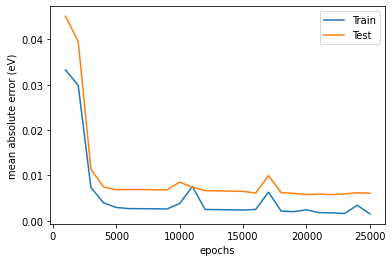

!!!propane_100!!!

epoch 1000, mae_train=0.038734521716833115, mae_valid=0.042614858597517014, % valid chemical accuracy=0.574999988079071
epoch 2000, mae_train=0.019648244604468346, mae_valid=0.021823406219482422, % valid chemical accuracy=0.875
epoch 3000, mae_train=0.009248686023056507, mae_valid=0.009170081466436386, % valid chemical accuracy=1.0
epoch 4000, mae_train=0.004696288146078587, mae_valid=0.005276288837194443, % valid chemical accuracy=1.0
epoch 5000, mae_train=0.00456972373649478, mae_valid=0.005162893794476986, % valid chemical accuracy=1.0
epoch 6000, mae_train=0.004590132273733616, mae_valid=0.005117872729897499, % valid chemical accuracy=1.0
epoch 7000, mae_train=0.004461957141757011, mae_valid=0.004987931344658136, % valid chemical accuracy=1.0
epoch 8000, mae_train=0.004422585945576429, mae_valid=0.004941115155816078, % valid chemical accuracy=1.0
epoch 9000, mae_train=0.004391529597342014, mae_valid=0.00492448965087533, % valid chemical accuracy=1.0
epoch 10000, 

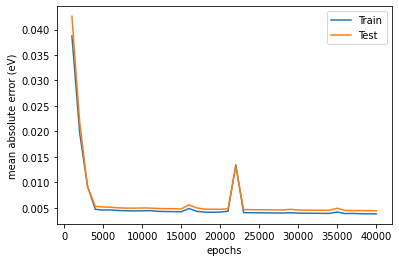

!!!propane_800!!!

epoch 1000, mae_train=0.03916336968541145, mae_valid=0.04267691448330879, % valid chemical accuracy=0.5699999928474426
epoch 2000, mae_train=0.026761483401060104, mae_valid=0.02925027348101139, % valid chemical accuracy=0.7749999761581421
epoch 3000, mae_train=0.00552873220294714, mae_valid=0.005360417999327183, % valid chemical accuracy=1.0
epoch 4000, mae_train=0.0053219604305922985, mae_valid=0.0050305211916565895, % valid chemical accuracy=1.0
epoch 5000, mae_train=0.0052731395699083805, mae_valid=0.00494062015786767, % valid chemical accuracy=1.0
epoch 6000, mae_train=0.0052355513907969, mae_valid=0.004884148016571999, % valid chemical accuracy=1.0
epoch 7000, mae_train=0.00519789382815361, mae_valid=0.004836972802877426, % valid chemical accuracy=1.0
epoch 8000, mae_train=0.005152659956365824, mae_valid=0.004783547483384609, % valid chemical accuracy=1.0
epoch 9000, mae_train=0.005226729437708855, mae_valid=0.005045563448220491, % valid chemical accuracy=1.0
ep

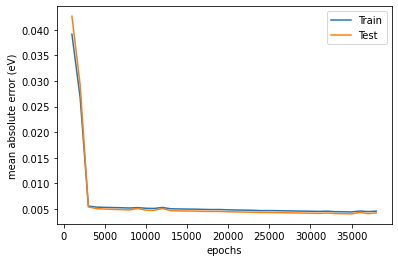

!!!water_10!!!

epoch 1000, mae_train=0.015781724825501442, mae_valid=0.026226336136460304, % valid chemical accuracy=0.8050000071525574
epoch 2000, mae_train=0.006215367000550032, mae_valid=0.007485453970730305, % valid chemical accuracy=1.0
epoch 3000, mae_train=0.00514217047020793, mae_valid=0.006437656935304403, % valid chemical accuracy=1.0
epoch 4000, mae_train=0.00466656731441617, mae_valid=0.006335897371172905, % valid chemical accuracy=1.0
epoch 5000, mae_train=0.00426493352279067, mae_valid=0.006054694298654795, % valid chemical accuracy=1.0
epoch 6000, mae_train=0.003892545821145177, mae_valid=0.005686298478394747, % valid chemical accuracy=1.0
epoch 7000, mae_train=0.0034424697514623404, mae_valid=0.004609569441527128, % valid chemical accuracy=1.0
epoch 8000, mae_train=0.0032262620516121387, mae_valid=0.0044203633442521095, % valid chemical accuracy=1.0
epoch 9000, mae_train=0.0026085523422807455, mae_valid=0.004175752401351929, % valid chemical accuracy=1.0
epoch 10000, m

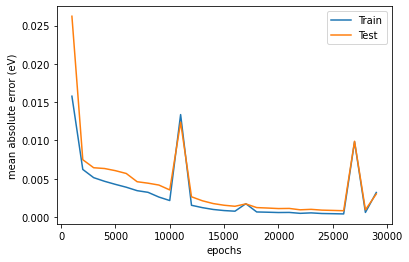

!!!water_100!!!

epoch 1000, mae_train=0.006506492383778095, mae_valid=0.0066795735619962215, % valid chemical accuracy=1.0
epoch 2000, mae_train=0.005713365972042084, mae_valid=0.006069754716008902, % valid chemical accuracy=1.0
epoch 3000, mae_train=0.004999254364520311, mae_valid=0.005196765065193176, % valid chemical accuracy=1.0
epoch 4000, mae_train=0.004103189334273338, mae_valid=0.004447673913091421, % valid chemical accuracy=1.0
epoch 5000, mae_train=0.003350659506395459, mae_valid=0.0034954792354255915, % valid chemical accuracy=1.0
epoch 6000, mae_train=0.0025065557565540075, mae_valid=0.0025606690905988216, % valid chemical accuracy=1.0
epoch 7000, mae_train=0.0016341778682544827, mae_valid=0.0016848765080794692, % valid chemical accuracy=1.0
epoch 8000, mae_train=0.0010839280439540744, mae_valid=0.0011188257485628128, % valid chemical accuracy=1.0
epoch 9000, mae_train=0.0008530309423804283, mae_valid=0.0008826089324429631, % valid chemical accuracy=1.0
epoch 10000, mae_tr

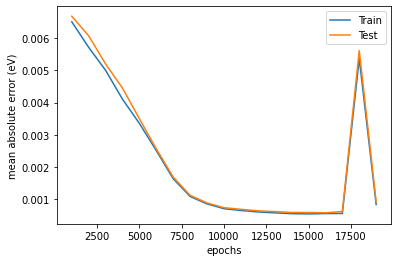

!!!water_800!!!

epoch 1000, mae_train=0.007047668565064669, mae_valid=0.006963778752833605, % valid chemical accuracy=1.0
epoch 2000, mae_train=0.005923103075474501, mae_valid=0.006027337163686752, % valid chemical accuracy=1.0
epoch 3000, mae_train=0.005139161366969347, mae_valid=0.00523817865177989, % valid chemical accuracy=1.0
epoch 4000, mae_train=0.004383215215057135, mae_valid=0.004481427371501923, % valid chemical accuracy=1.0
epoch 5000, mae_train=0.0035590236075222492, mae_valid=0.0036377867218106985, % valid chemical accuracy=1.0
epoch 6000, mae_train=0.0026810127310454845, mae_valid=0.00275052129290998, % valid chemical accuracy=1.0
epoch 7000, mae_train=0.0018696216866374016, mae_valid=0.0019072584109380841, % valid chemical accuracy=1.0
epoch 8000, mae_train=0.010762917809188366, mae_valid=0.010929113253951073, % valid chemical accuracy=1.0
epoch 9000, mae_train=0.0009306672727689147, mae_valid=0.000978935044258833, % valid chemical accuracy=1.0
epoch 10000, mae_train=0.

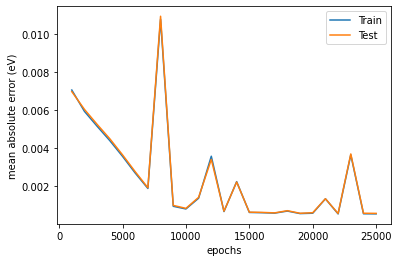

!!!benzene_10!!!

epoch 1000, mae_train=4.573178768157959, mae_valid=4.57727575302124, % valid chemical accuracy=0.0
epoch 2000, mae_train=0.9862695932388306, mae_valid=0.9903671145439148, % valid chemical accuracy=0.0
epoch 3000, mae_train=0.06859159469604492, mae_valid=0.07268901914358139, % valid chemical accuracy=0.054999999701976776
epoch 4000, mae_train=0.014849567785859108, mae_valid=0.015441074036061764, % valid chemical accuracy=0.9549999833106995
epoch 5000, mae_train=0.014850235544145107, mae_valid=0.015333294868469238, % valid chemical accuracy=0.9649999737739563
epoch 6000, mae_train=0.014850235544145107, mae_valid=0.015330142341554165, % valid chemical accuracy=0.9649999737739563
epoch 7000, mae_train=0.014849948696792126, mae_valid=0.015328092500567436, % valid chemical accuracy=0.9649999737739563
epoch 8000, mae_train=0.014849948696792126, mae_valid=0.01532695721834898, % valid chemical accuracy=0.9649999737739563
epoch 9000, mae_train=0.014850235544145107, mae_valid=0.

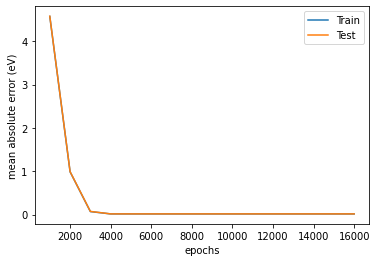

!!!benzene_100!!!

epoch 1000, mae_train=4.575473308563232, mae_valid=4.576876163482666, % valid chemical accuracy=0.0
epoch 2000, mae_train=0.9873539805412292, mae_valid=0.9887568354606628, % valid chemical accuracy=0.0
epoch 3000, mae_train=0.06874585896730423, mae_valid=0.07014873623847961, % valid chemical accuracy=0.07499999552965164
epoch 4000, mae_train=0.01479074452072382, mae_valid=0.015071372501552105, % valid chemical accuracy=0.9799999594688416
epoch 5000, mae_train=0.014803695492446423, mae_valid=0.01502414233982563, % valid chemical accuracy=0.98499995470047
epoch 6000, mae_train=0.014804114587605, mae_valid=0.01502288319170475, % valid chemical accuracy=0.98499995470047
epoch 7000, mae_train=0.014804763719439507, mae_valid=0.015022548846900463, % valid chemical accuracy=0.98499995470047
epoch 8000, mae_train=0.014804935082793236, mae_valid=0.01502208225429058, % valid chemical accuracy=0.98499995470047
epoch 9000, mae_train=0.014805126003921032, mae_valid=0.0150219295173

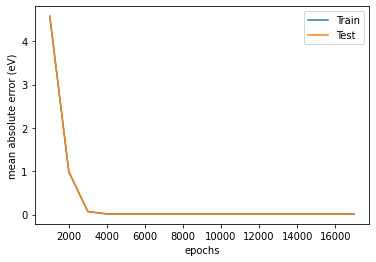

!!!benzene_800!!!

epoch 1000, mae_train=4.576075553894043, mae_valid=4.576761245727539, % valid chemical accuracy=0.0
epoch 2000, mae_train=0.9876327514648438, mae_valid=0.9883183240890503, % valid chemical accuracy=0.0
epoch 3000, mae_train=0.0687844380736351, mae_valid=0.06947004050016403, % valid chemical accuracy=0.07999999821186066
epoch 4000, mae_train=0.01336384005844593, mae_valid=0.015019802376627922, % valid chemical accuracy=0.98499995470047
epoch 5000, mae_train=0.01336486916989088, mae_valid=0.014990557916462421, % valid chemical accuracy=0.9799999594688416
epoch 6000, mae_train=0.01336507499217987, mae_valid=0.014989981427788734, % valid chemical accuracy=0.9799999594688416
epoch 7000, mae_train=0.013365167193114758, mae_valid=0.014989685267210007, % valid chemical accuracy=0.9799999594688416
epoch 8000, mae_train=0.013365239836275578, mae_valid=0.014989527873694897, % valid chemical accuracy=0.9799999594688416
epoch 9000, mae_train=0.013365330174565315, mae_valid=0.0149

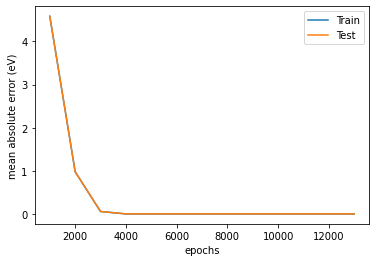

!!!methanol_10!!!

epoch 1000, mae_train=0.008612957783043385, mae_valid=0.015098359435796738, % valid chemical accuracy=0.9799999594688416
epoch 2000, mae_train=0.007224404718726873, mae_valid=0.011557440273463726, % valid chemical accuracy=1.0
epoch 3000, mae_train=0.0070388587191700935, mae_valid=0.011254333890974522, % valid chemical accuracy=1.0
epoch 4000, mae_train=0.006841757800430059, mae_valid=0.010968250222504139, % valid chemical accuracy=1.0
epoch 5000, mae_train=0.0065489946864545345, mae_valid=0.010994946584105492, % valid chemical accuracy=1.0
epoch 6000, mae_train=0.0076439292170107365, mae_valid=0.0129977036267519, % valid chemical accuracy=1.0
epoch 7000, mae_train=0.005992993712425232, mae_valid=0.009776008315384388, % valid chemical accuracy=1.0
epoch 8000, mae_train=0.0055552395060658455, mae_valid=0.009687046520411968, % valid chemical accuracy=1.0
epoch 9000, mae_train=0.005109402816742659, mae_valid=0.008677580393850803, % valid chemical accuracy=1.0
epoch 1000

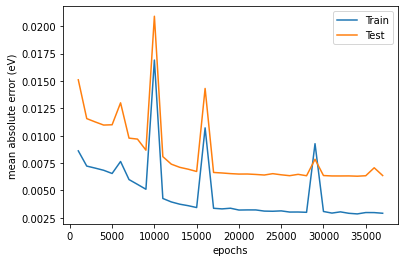

!!!methanol_100!!!

epoch 1000, mae_train=0.009691551327705383, mae_valid=0.011580129154026508, % valid chemical accuracy=0.9950000047683716
epoch 2000, mae_train=0.008434704504907131, mae_valid=0.009626475162804127, % valid chemical accuracy=1.0
epoch 3000, mae_train=0.007426741067320108, mae_valid=0.008487043902277946, % valid chemical accuracy=1.0
epoch 4000, mae_train=0.006944458466023207, mae_valid=0.007977892644703388, % valid chemical accuracy=1.0
epoch 5000, mae_train=0.006726727820932865, mae_valid=0.007660095579922199, % valid chemical accuracy=1.0
epoch 6000, mae_train=0.006461780983954668, mae_valid=0.007775187958031893, % valid chemical accuracy=1.0
epoch 7000, mae_train=0.006384197156876326, mae_valid=0.007398808840662241, % valid chemical accuracy=1.0
epoch 8000, mae_train=0.006145881488919258, mae_valid=0.00717848539352417, % valid chemical accuracy=1.0
epoch 9000, mae_train=0.005878877360373735, mae_valid=0.007008479908108711, % valid chemical accuracy=1.0
epoch 10000,

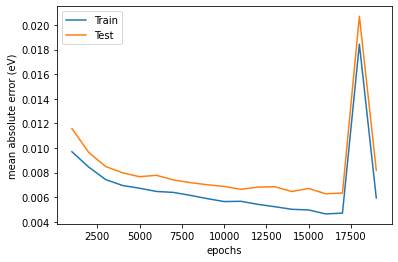

!!!methanol_800!!!

epoch 1000, mae_train=0.010168413631618023, mae_valid=0.011503105983138084, % valid chemical accuracy=0.9899999499320984
epoch 2000, mae_train=0.008678022772073746, mae_valid=0.009077697061002254, % valid chemical accuracy=0.9950000047683716
epoch 3000, mae_train=0.007756415288895369, mae_valid=0.008130298927426338, % valid chemical accuracy=1.0
epoch 4000, mae_train=0.007326505146920681, mae_valid=0.007425472140312195, % valid chemical accuracy=1.0
epoch 5000, mae_train=0.007228902541100979, mae_valid=0.007371106650680304, % valid chemical accuracy=1.0
epoch 6000, mae_train=0.00918518751859665, mae_valid=0.009132896549999714, % valid chemical accuracy=0.9950000047683716
epoch 7000, mae_train=0.006823473609983921, mae_valid=0.006797289475798607, % valid chemical accuracy=1.0
epoch 8000, mae_train=0.006675823125988245, mae_valid=0.006648886017501354, % valid chemical accuracy=1.0
epoch 9000, mae_train=0.006494633853435516, mae_valid=0.00647314777597785, % valid chemi

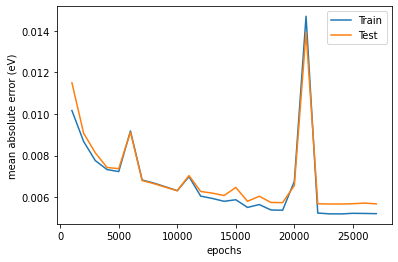

In [ ]:
for name in ["propane","water","benzene", "methanol"]:
    Tr, Te = split_data([name])
    for n in [10,100,800]:
        print(f"!!!{name}_{n}!!!\n")
        model_tmp = GCN()
        model_tmp.to("cuda")
        model_tmp, loss_history = train_model(model_tmp, select_k(Tr, k=n), select_k(Te, k=200), max_iter=40000, model_name=f"{name}_{n}.pt")
        plot_loss(loss_history)


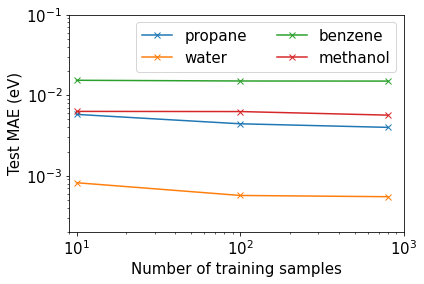

In [ ]:
plt.plot([10,100,800],[0.00578, 0.00442, 0.00399],'x-',label="propane")
plt.plot([10,100,800],[0.00082, 0.00057, 0.00055],'x-',label="water")
plt.plot([10,100,800],[0.01533, 0.01502, 0.01498],'x-',label="benzene")
plt.plot([10,100,800],[0.0063,0.00627, 0.00566],'x-',label="methanol")
plt.xlabel("Number of training samples")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Test MAE (eV)")
plt.ylim([0.0002,0.1])
plt.xlim([9,1e3])
plt.legend(ncol=2, loc="best")
plt.savefig("Plots/GNN_efficiency.pdf",bbox_inches='tight')
plt.show()

## all cheng's

In [ ]:
ChengTr, ChengTe = split_data(['methane', 'ethane', 'propane', 'butane', 'isobutane', 'water'])
model_Cheng = GCN().to("cuda")
Model_Cheng, loss_history = train_model(model_Cheng, ChengTr, ChengTe, max_iter=100000, model_name=f"Cheng_data.pt")

epoch 1000, mae_train=0.03404688462615013, mae_valid=0.03298215940594673, % valid chemical accuracy=0.7375565767288208
epoch 2000, mae_train=0.02329953759908676, mae_valid=0.022612450644373894, % valid chemical accuracy=0.8536953330039978
epoch 3000, mae_train=0.015415634959936142, mae_valid=0.014660583809018135, % valid chemical accuracy=0.9291101098060608
epoch 4000, mae_train=0.01727454923093319, mae_valid=0.01629132591187954, % valid chemical accuracy=0.8944193124771118
epoch 5000, mae_train=0.010243400000035763, mae_valid=0.009841231629252434, % valid chemical accuracy=0.9728506803512573
epoch 6000, mae_train=0.008672038093209267, mae_valid=0.008534952998161316, % valid chemical accuracy=0.9909502267837524
epoch 7000, mae_train=0.008062460459768772, mae_valid=0.008030212484300137, % valid chemical accuracy=0.9954751133918762
epoch 8000, mae_train=0.05544884130358696, mae_valid=0.056007180362939835, % valid chemical accuracy=0.3257918655872345
epoch 9000, mae_train=0.00769264623522

In [ ]:
ChengTr, ChengTe = split_data(['methane', 'ethane', 'propane', 'butane', 'isobutane', 'water'])
Cheng_best = torch.load("Models_GNN/Cheng_data.pt")
yTe, yTe_pred = eval_model(Cheng_best, ChengTe)

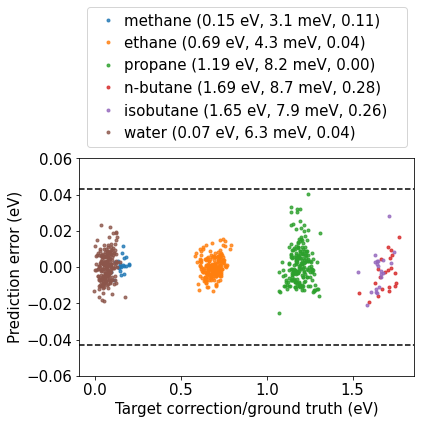

In [ ]:
break_points = [0,21,221,421,442,463,663]
mols = ['methane', 'ethane', 'propane', 'n-butane', 'isobutane', 'water']
for start, end, name in zip(break_points[:-1], break_points[1:], mols):
    mae = np.mean(np.abs(yTe[start:end]-yTe_pred[start:end]))*1000
    correlation_matrix = np.corrcoef(yTe[start:end], yTe[start:end]-yTe_pred[start:end])
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    plt.plot(yTe[start:end], yTe[start:end]-yTe_pred[start:end],'.', label=f"{name} ({np.mean(yTe[start:end]):.2f} eV, {mae:.1f} meV, {r_squared:.2f})", alpha=0.8)
plt.ylim(-0.06,0.06)
plt.axhline(y=0.043, color='k', linestyle='--')
plt.axhline(y=-0.043, color='k', linestyle='--')
plt.xlabel("Target correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.legend(ncol=1, loc='lower left', bbox_to_anchor=(0,1.02,1,0.2), mode="expand", handletextpad=0.1)
plt.savefig("Plots/Cheng_GNN.pdf", bbox_inches='tight')
plt.show()

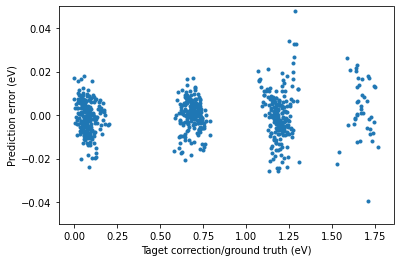

In [ ]:
plt.plot(yTest_Cheng, yTest_pred_Cheng-yTest_Cheng,'.')
plt.ylim(-0.05,0.05)
plt.xlabel("Taget correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.savefig("Plots/Cheng_GNN.pdf")
plt.show()

## Chimela's benzene, toluene, malonaldehyde

In [ ]:
ChimelaTr, ChimelaTe = split_data(['benzene', 'toluene', 'malonaldehyde'])
model_Chimela = GCN().to("cuda")
Model_Chimela, loss_history = train_model(model_Chimela, ChimelaTr,
                                        ChimelaTe, max_iter=100000, model_name=f"Chimela_data.pt")

epoch 1000, mae_train=0.8212878704071045, mae_valid=0.8227642774581909, % valid chemical accuracy=0.0
epoch 2000, mae_train=0.7737961411476135, mae_valid=0.772967517375946, % valid chemical accuracy=0.23196449875831604
epoch 3000, mae_train=0.7737995386123657, mae_valid=0.7729706764221191, % valid chemical accuracy=0.23085461556911469
epoch 4000, mae_train=0.7737893462181091, mae_valid=0.7729604840278625, % valid chemical accuracy=0.23085461556911469
epoch 5000, mae_train=0.7737836837768555, mae_valid=0.7729548215866089, % valid chemical accuracy=0.23085461556911469
epoch 6000, mae_train=0.7737829685211182, mae_valid=0.7729540467262268, % valid chemical accuracy=0.23085461556911469
epoch 7000, mae_train=0.7737828493118286, mae_valid=0.7729540467262268, % valid chemical accuracy=0.23085461556911469
epoch 8000, mae_train=0.7737827301025391, mae_valid=0.7729538679122925, % valid chemical accuracy=0.23085461556911469
epoch 9000, mae_train=0.28574806451797485, mae_valid=0.29156625270843506,

In [ ]:
ChimelaTr, ChimelaTe = split_data(['benzene', 'toluene', 'malonaldehyde'])
best_model = torch.load("Models_GNN/Chimela_data.pt")
yTe, yTe_pred = eval_model(best_model, ChimelaTe)

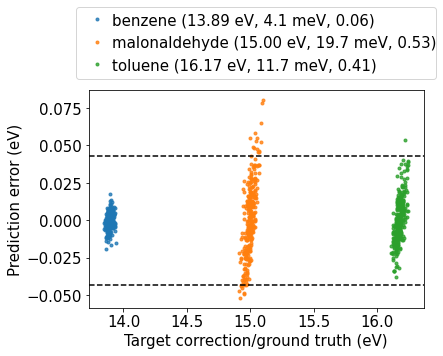

In [ ]:
break_points_0 = [0,601,300]
break_points_1 = [300,901,601]
mols = ['benzene', 'malonaldehyde', 'toluene']
for start, end, name in zip(break_points_0, break_points_1, mols):
    mae = np.mean(np.abs(yTe[start:end]-yTe_pred[start:end]))*1000
    correlation_matrix = np.corrcoef(yTe[start:end], yTe[start:end]-yTe_pred[start:end])
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    plt.plot(yTe[start:end], yTe[start:end]-yTe_pred[start:end],'.', label=f"{name} ({np.mean(yTe[start:end]):.2f} eV, {mae:.1f} meV, {r_squared:.2f})", alpha=0.8)
#plt.ylim(-0.06,0.06)
plt.axhline(y=0.043, color='k', linestyle='--')
plt.axhline(y=-0.043, color='k', linestyle='--')
plt.xlabel("Target correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.legend(ncol=1, loc='lower left', bbox_to_anchor=(-0.06,1.02,1.12,0.2), mode="expand", handletextpad=0.000001)
plt.savefig("Plots/Chimela_GNN.pdf", bbox_inches='tight')
plt.show()

In [ ]:
Chimela_best = torch.load("Models_GNN/Chimela_data.pt")
yTest_Chimela, yTest_pred_Chimela = eval_model(Chimela_best, ChimelaTe)

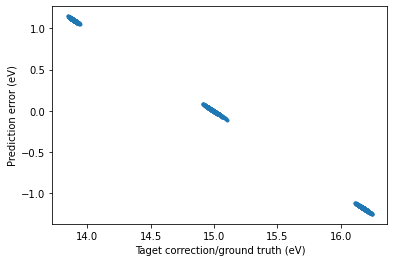

In [ ]:
plt.plot(yTest_Chimela, yTest_pred_Chimela-yTest_Chimela,'.')
#plt.ylim(-0.05,0.05)
plt.xlabel("Taget correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.savefig("Plots/Chimela_GNN.pdf")
plt.show()

## ccpvtz experiment

In [ ]:
pvtzTr, pvtzTe = split_data(['methane', 'ethane', 'propane', 'butane', 'isobutane', 'water', 'ethanol', 'methanol'])
model_pvtz = GCN().to("cuda")
Model_pvtz, loss_history = train_model(model_pvtz, pvtzTr, pvtzTe, max_iter=100000, model_name=f"pvtz_data.pt")

epoch 1000, mae_train=0.3090222477912903, mae_valid=0.31225794553756714, % valid chemical accuracy=0.1852731555700302
epoch 2000, mae_train=0.07617726176977158, mae_valid=0.07857660949230194, % valid chemical accuracy=0.5439429879188538
epoch 3000, mae_train=0.03942432627081871, mae_valid=0.0400409996509552, % valid chemical accuracy=0.7022961378097534
epoch 4000, mae_train=0.037417877465486526, mae_valid=0.03738861903548241, % valid chemical accuracy=0.7205067276954651
epoch 5000, mae_train=0.01921365037560463, mae_valid=0.018946677446365356, % valid chemical accuracy=0.9026128053665161
epoch 6000, mae_train=0.017706340178847313, mae_valid=0.017931044101715088, % valid chemical accuracy=0.9224069714546204
epoch 7000, mae_train=0.12631720304489136, mae_valid=0.12457876652479172, % valid chemical accuracy=0.16627077758312225
epoch 8000, mae_train=0.016273096203804016, mae_valid=0.016479935497045517, % valid chemical accuracy=0.9414093494415283
epoch 9000, mae_train=0.12804481387138367, 

In [ ]:
pvtzTr, pvtzTe = split_data(['methane', 'ethane', 'propane', 'butane', 'isobutane', 'water', 'ethanol', 'methanol'])
best_model = torch.load("Models_GNN/pvtz_data.pt")
yTe, yTe_pred = eval_model(best_model, pvtzTe)

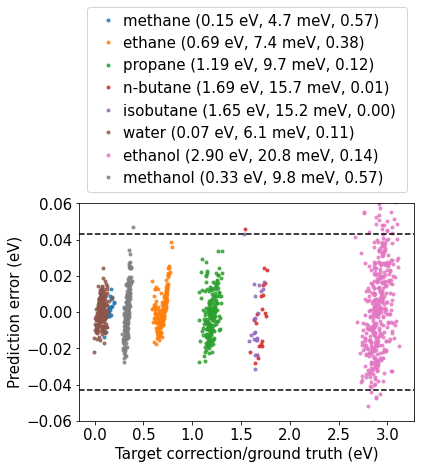

In [ ]:
break_points_0 = [0,21,221,421,442,463,663,1063]
break_points_1 = [21,221,421,442,463,663,1063,1263]
mols = ['methane', 'ethane', 'propane', 'n-butane', 'isobutane', 'water', 'ethanol', 'methanol']
for start, end, name in zip(break_points_0, break_points_1, mols):
    mae = np.mean(np.abs(yTe[start:end]-yTe_pred[start:end]))*1000
    correlation_matrix = np.corrcoef(yTe[start:end], yTe[start:end]-yTe_pred[start:end])
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    plt.plot(yTe[start:end], yTe[start:end]-yTe_pred[start:end],'.', label=f"{name} ({np.mean(yTe[start:end]):.2f} eV, {mae:.1f} meV, {r_squared:.2f})", alpha=0.8)
plt.ylim(-0.06,0.06)
plt.axhline(y=0.043, color='k', linestyle='--')
plt.axhline(y=-0.043, color='k', linestyle='--')
plt.xlabel("Target correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.legend(ncol=1, loc='lower left', bbox_to_anchor=(0,1.02,1,0.2), mode="expand", handletextpad=0.000001)
plt.savefig("Plots/pvtz_GNN.pdf", bbox_inches='tight')
plt.show()

In [ ]:
pvtz_best = torch.load("Models_GNN/pvtz_data.pt")
yTest_pvtz, yTest_pred_pvtz = eval_model(pvtz_best, pvtzTe)

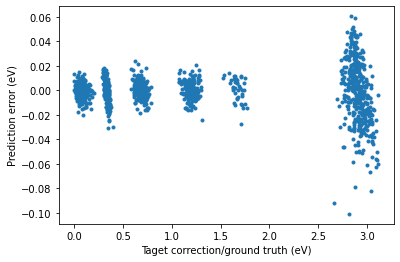

In [ ]:
plt.plot(yTest_pvtz, yTest_pred_pvtz-yTest_pvtz,'.')
#plt.ylim(-0.05,0.05)
plt.xlabel("Taget correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.savefig("Plots/pvtz_GNN.pdf")
plt.show()

## ccpvdz experiment

In [ ]:
pvdzTr, pvdzTe = split_data(['benzene', 'toluene', 'malonaldehyde', 'ethanal', 'dimethylether'])
model_pvdz = GCN().to("cuda")
Model_pvdz, loss_history = train_model(model_pvdz, pvdzTr, pvdzTe, max_iter=100000, model_name=f"pvdz_data.pt")

epoch 1000, mae_train=0.8573015928268433, mae_valid=0.8584597110748291, % valid chemical accuracy=0.028439661487936974
epoch 2000, mae_train=0.5637621879577637, mae_valid=0.564249575138092, % valid chemical accuracy=0.22828592360019684
epoch 3000, mae_train=0.5417152047157288, mae_valid=0.5416357517242432, % valid chemical accuracy=0.4404304325580597
epoch 4000, mae_train=0.5377934575080872, mae_valid=0.5376752614974976, % valid chemical accuracy=0.4773251414299011
epoch 5000, mae_train=0.5380613207817078, mae_valid=0.5377658605575562, % valid chemical accuracy=0.4750192165374756
epoch 6000, mae_train=0.5377613306045532, mae_valid=0.5375269055366516, % valid chemical accuracy=0.47425055503845215
epoch 7000, mae_train=0.5386661291122437, mae_valid=0.5382584929466248, % valid chemical accuracy=0.4788624048233032
epoch 8000, mae_train=0.5376793146133423, mae_valid=0.5374329090118408, % valid chemical accuracy=0.4773251414299011
epoch 9000, mae_train=0.5372822284698486, mae_valid=0.5370922

In [ ]:
pvdzTr, pvdzTe = split_data(['benzene', 'toluene', 'malonaldehyde', 'ethanal', 'dimethylether'])
best_model = torch.load("Models_GNN/pvdz_data.pt")
yTe, yTe_pred = eval_model(best_model, pvdzTe)

In [ ]:
yTe.shape

(1301,)

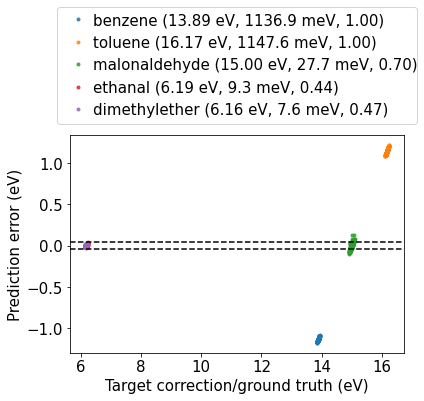

In [ ]:
break_points_0 = [0,300,601,901,1101]
break_points_1 = [300,601,901,1101,1301]
mols = ['benzene', 'toluene', 'malonaldehyde', 'ethanal', 'dimethylether']
for start, end, name in zip(break_points_0, break_points_1, mols):
    mae = np.mean(np.abs(yTe[start:end]-yTe_pred[start:end]))*1000
    correlation_matrix = np.corrcoef(yTe[start:end], yTe[start:end]-yTe_pred[start:end])
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    plt.plot(yTe[start:end], yTe[start:end]-yTe_pred[start:end],'.', label=f"{name} ({np.mean(yTe[start:end]):.2f} eV, {mae:.1f} meV, {r_squared:.2f})", alpha=0.8)
#plt.ylim(-0.14,0.11)
plt.axhline(y=0.043, color='k', linestyle='--')
plt.axhline(y=-0.043, color='k', linestyle='--')
plt.xlabel("Target correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.legend(ncol=1, loc='lower left', bbox_to_anchor=(-0.06,1.02,1.12,0.2), mode="expand", handletextpad=0.000001)
plt.savefig("Plots/pvdz_GNN.pdf", bbox_inches='tight')
plt.show()

In [ ]:
pvdz_best = torch.load("Models_GNN/pvdz_data.pt")
yTest_pvdz, yTest_pred_pvdz = eval_model(pvdz_best, pvdzTe)

In [ ]:
plt.plot(yTest_pttz, yTest_pred_pvtz-yTest_pvtz,'.')
#plt.ylim(-0.05,0.05)
plt.xlabel("Taget correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.savefig("Plots/pvtz_GNN.pdf")
plt.show()

## transferability

In [ ]:
mepTr, mepTe = split_data(['methane','ethane','propane'])
model_mep = GCN().to("cuda")
Model_mep, loss_history = train_model(model_mep, mepTr, mepTe, max_iter=100000, model_name=f"mep_data.pt")

epoch 1000, mae_train=0.06089574098587036, mae_valid=0.05811901390552521, % valid chemical accuracy=0.3729216456413269
epoch 2000, mae_train=0.023960120975971222, mae_valid=0.02371360920369625, % valid chemical accuracy=0.8527316451072693
epoch 3000, mae_train=0.015645811334252357, mae_valid=0.015608934685587883, % valid chemical accuracy=0.9548693895339966
epoch 4000, mae_train=0.011587794870138168, mae_valid=0.011750460602343082, % valid chemical accuracy=0.9904988408088684
epoch 5000, mae_train=0.009579654783010483, mae_valid=0.009733946062624454, % valid chemical accuracy=0.9976247549057007
epoch 6000, mae_train=0.008618460036814213, mae_valid=0.0087234266102314, % valid chemical accuracy=1.0
epoch 7000, mae_train=0.008025221526622772, mae_valid=0.008155579678714275, % valid chemical accuracy=1.0
epoch 8000, mae_train=0.007310791406780481, mae_valid=0.007385152857750654, % valid chemical accuracy=1.0
epoch 9000, mae_train=0.006589395459741354, mae_valid=0.006582783069461584, % vali

### test on butane/isobutane

In [ ]:
biTr, biTe = split_data(['butane', 'isobutane'], ratio=1)
best_model = torch.load("Models_GNN/mep_data.pt")
yTe, yTe_pred = eval_model(best_model, biTr)

In [ ]:
yTe.shape

(202,)

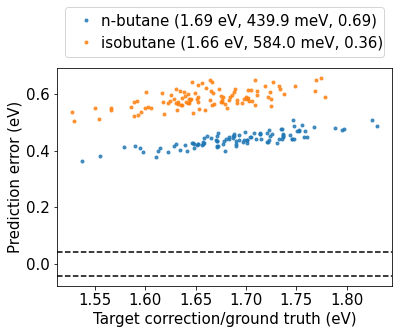

In [ ]:
break_points_0 = [0,101]
break_points_1 = [101,202]
mols = ['n-butane', 'isobutane']
for start, end, name in zip(break_points_0, break_points_1, mols):
    mae = np.mean(np.abs(yTe[start:end]-yTe_pred[start:end]))*1000
    correlation_matrix = np.corrcoef(yTe[start:end], yTe[start:end]-yTe_pred[start:end])
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    plt.plot(yTe[start:end], yTe[start:end]-yTe_pred[start:end],'.', label=f"{name} ({np.mean(yTe[start:end]):.2f} eV, {mae:.1f} meV, {r_squared:.2f})", alpha=0.8)
#plt.ylim(-0.06,0.06)
plt.axhline(y=0.043, color='k', linestyle='--')
plt.axhline(y=-0.043, color='k', linestyle='--')
plt.xlabel("Target correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.legend(ncol=1, loc='lower left', bbox_to_anchor=(0,1.02,1,0.2), mode="expand", handletextpad=0.000001)
plt.savefig("Plots/GNN_transfer_butane_isobutane.pdf", bbox_inches='tight')
plt.show()

### test on ethylene acetylene propene

In [ ]:
eapTr, eapTe = split_data(['ethylene', 'acetylene', 'propene'], ratio=1)
best_model = torch.load("Models_GNN/mep_data.pt")
yTe, yTe_pred = eval_model(best_model, eapTr)

In [ ]:
yTe.shape

(300,)

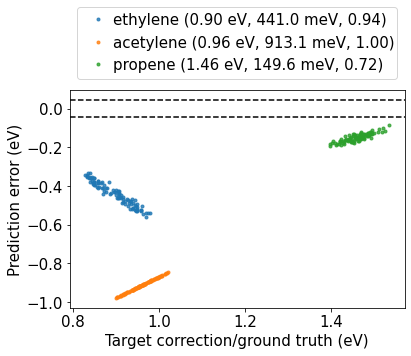

In [ ]:
break_points_0 = [0,100,200]
break_points_1 = [100,200,300]
mols = ['ethylene', 'acetylene', 'propene']
for start, end, name in zip(break_points_0, break_points_1, mols):
    mae = np.mean(np.abs(yTe[start:end]-yTe_pred[start:end]))*1000
    correlation_matrix = np.corrcoef(yTe[start:end], yTe[start:end]-yTe_pred[start:end])
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    plt.plot(yTe[start:end], yTe[start:end]-yTe_pred[start:end],'.', label=f"{name} ({np.mean(yTe[start:end]):.2f} eV, {mae:.1f} meV, {r_squared:.2f})", alpha=0.8)
#plt.ylim(-0.06,0.06)
plt.axhline(y=0.043, color='k', linestyle='--')
plt.axhline(y=-0.043, color='k', linestyle='--')
plt.xlabel("Target correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.legend(ncol=1, loc='lower left', bbox_to_anchor=(0,1.02,1,0.2), mode="expand", handletextpad=0.000001)
plt.savefig("Plots/GNN_transfer_ethylene_acetylene_propene.pdf", bbox_inches='tight')
plt.show()

## methane alone

In [ ]:
ch4Tr, ch4Te = split_data(['methane'])
model_ch4 = GCN().to("cuda")
Model_ch4, loss_history = train_model(model_ch4, ch4Tr, ch4Te, max_iter=100000, model_name=f"ch4_data.pt")

epoch 1000, mae_train=0.02848781645298004, mae_valid=0.01888163946568966, % valid chemical accuracy=0.9047619104385376
epoch 2000, mae_train=0.02503327839076519, mae_valid=0.01675698161125183, % valid chemical accuracy=0.9523809552192688
epoch 3000, mae_train=0.0045105102472007275, mae_valid=0.003920127637684345, % valid chemical accuracy=1.0
epoch 4000, mae_train=0.0034584812819957733, mae_valid=0.0031334534287452698, % valid chemical accuracy=1.0
epoch 5000, mae_train=0.0033501789439469576, mae_valid=0.003033064305782318, % valid chemical accuracy=1.0
epoch 6000, mae_train=0.0032238983549177647, mae_valid=0.0029203686863183975, % valid chemical accuracy=1.0
epoch 7000, mae_train=0.003458508988842368, mae_valid=0.0030734813772141933, % valid chemical accuracy=1.0
epoch 8000, mae_train=0.0029972230549901724, mae_valid=0.0027158050797879696, % valid chemical accuracy=1.0
epoch 9000, mae_train=0.0028862403705716133, mae_valid=0.0026161568239331245, % valid chemical accuracy=1.0
epoch 100

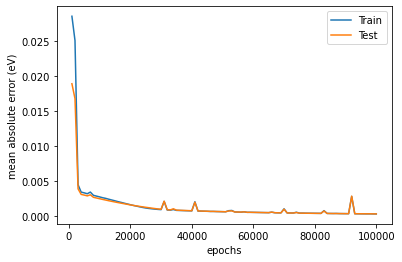

In [ ]:
plot_loss(loss_history)

In [ ]:
ch4Tr, ch4Te = split_data(['methane'])

In [ ]:
best_model = torch.load("Models_GNN/ch4_data.pt")
yTe, yTe_pred = eval_model(best_model, ch4Te)

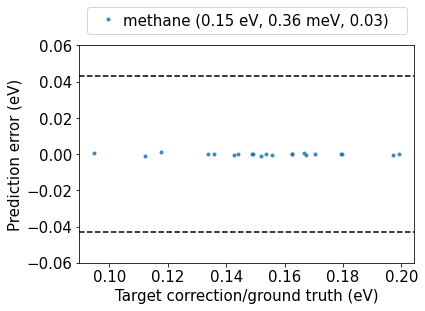

In [ ]:
break_points_0 = [0]
break_points_1 = [21]
mols = ['methane']
for start, end, name in zip(break_points_0, break_points_1, mols):
    mae = np.mean(np.abs(yTe[start:end]-yTe_pred[start:end]))*1000
    correlation_matrix = np.corrcoef(yTe[start:end], yTe[start:end]-yTe_pred[start:end])
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    plt.plot(yTe[start:end], yTe[start:end]-yTe_pred[start:end],'.', label=f"{name} ({np.mean(yTe[start:end]):.2f} eV, {mae:.2f} meV, {r_squared:.2f})", alpha=0.8)
plt.ylim(-0.06,0.06)
plt.axhline(y=0.043, color='k', linestyle='--')
plt.axhline(y=-0.043, color='k', linestyle='--')
plt.xlabel("Target correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.legend(ncol=1, loc='lower left', bbox_to_anchor=(0,1.02,1,0.2), mode="expand", handletextpad=0.000001)
plt.savefig("Plots/GNN_ch4.pdf", bbox_inches='tight')
plt.show()

In [ ]:
ch4_best = torch.load("Models_GNN/ch4_data.pt")
yTest_ch4, yTest_pred_ch4 = eval_model(ch4_best, ch4Te)

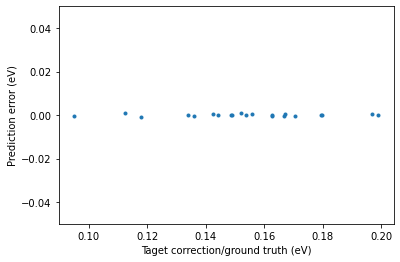

In [ ]:
plt.plot(yTest_ch4, yTest_pred_ch4-yTest_ch4,'.')
plt.ylim(-0.05,0.05)
plt.xlabel("Taget correction/ground truth (eV)")
plt.ylabel("Prediction error (eV)")
plt.savefig("Plots/ch4_GNN.pdf")
plt.show()